<a href="https://colab.research.google.com/github/shayan823/reward_related_society/blob/main/Data_Retrieval_Fede.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's start this project! 
Setting it up first and downloading  the data

In [1]:
# install IBL pipeline package to access and navigate the pipeline
!pip install --quiet nma-ibl
#pip install ibllib
import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt

#from one.api import ONE
#one = ONE(silent=True)


dj.config["database.host"] = "datajoint-public.internationalbrainlab.org"
dj.config["database.user"] = "ibl-public"
dj.config["database.password"] = "ibl-public" 

     |████████████████████████████████| 101 kB 9.1 MB/s 
     |████████████████████████████████| 76 kB 5.4 MB/s 
     |████████████████████████████████| 4.1 MB 66.4 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 78 kB 5.9 MB/s 


1. Meta data stored and imported from [**Alyx**](https://alyx.readthedocs.io/en/latest/):

    1) `ibl_reference`: general information about labs, users and projects  
    2) `ibl_subject`: information about the experiment subject including housing and genetics  
    3) `ibl_action`: information about performed surgeries
    4) `ibl_acquisition`: information about experimental sessions
    5) `ibl_data`: information pertaining to underlying data resource handling  
    
2. Behavioral data stored and imported from **FlatIron** data stores: `ibl_behavior` - trial information of the task.
3. Computed alalysis results on the behavioral data: `ibl_analyses_behavior`    

In [2]:
# Load tables
from nma_ibl import reference, subject, action, acquisition, data, behavior, behavior_analyses

[2022-07-22 13:02:04,739][INFO]: Connecting ibl-public@datajoint-public.internationalbrainlab.org:3306
[2022-07-22 13:02:04,990][INFO]: Connected ibl-public@datajoint-public.internationalbrainlab.org:3306


In [48]:
labs = subject.SubjectLab.fetch('lab_name')

lab_names = np.unique(labs)
counts = np.zeros_like(lab_names)

for idx, lab in enumerate(lab_names):
  counts[idx] = len(np.where(labs==lab)[0])

print('The lab with more mice is', lab_names[np.argmax(counts)], 'with', np.max(counts), 'mice')

counts
lab_names

array([26, 29, 4, 27, 17, 23, 41, 21, 24, 21], dtype=object)

## Calculate training days for each mice in mainenlab

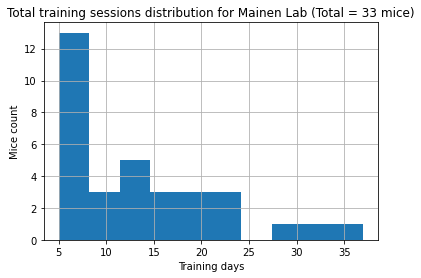

In [4]:
# Calculate total days until training for each mouse

(behavior_analyses.SessionTrainingStatus()) * subject.SubjectLab & 'lab_name = "mainenlab"'


mainen_mice_in_training = behavior_analyses.SessionTrainingStatus & 'training_status = "in_training" ' & (subject.SubjectLab & 'lab_name = "mainenlab"') 
mainen_mice = np.unique(mainen_mice_in_training.fetch('subject_uuid'))


id = mainen_mice_in_training.fetch('subject_uuid')
training_days = np.zeros_like(mainen_mice)

for idx, mouse in enumerate(mainen_mice):
  training_days[idx] = len(np.where(id == mouse)[0])

plt.title('Total training sessions distribution for Mainen Lab (Total = 33 mice)')
plt.xlabel('Training days')
plt.ylabel('Mice count')
plt.hist(training_days)
plt.grid()


In [110]:
def fetch_mice_by_percentage(percentage):
  dictionary = {}

  for mouse in mainen_mice:
    one_guy = mainen_mice_in_training & {'subject_uuid' : mouse}
    total_trials = len(one_guy.fetch('training_status'))
    train_percentage = np.arange(1,total_trials+1) / total_trials
    train_percentage_bin = ((train_percentage // 0.1) + 1)*10
    where = np.where(train_percentage_bin == percentage)[0]
    if len(where) !=0:
      dictionary[mouse] = one_guy.fetch('session_start_time')[where]
  return dictionary
  

In [112]:
fetch_mice_by_percentage(20)[mouse]

array([datetime.datetime(2019, 11, 19, 15, 10, 23),
       datetime.datetime(2019, 11, 20, 15, 30, 41)], dtype=object)

In [ ]:
mainen_mice_in_training

subject_uuid,session_start_time start time,training_status,good_enough_for_brainwide_map
034fd43f-ee35-450b-99ef-25475ce25fdc,2019-01-23 13:22:12,in_training,0
034fd43f-ee35-450b-99ef-25475ce25fdc,2019-01-24 16:40:45,in_training,0
034fd43f-ee35-450b-99ef-25475ce25fdc,2019-01-25 14:23:53,in_training,None
034fd43f-ee35-450b-99ef-25475ce25fdc,2019-01-28 14:47:48,in_training,None
034fd43f-ee35-450b-99ef-25475ce25fdc,2019-01-29 15:51:31,in_training,None
034fd43f-ee35-450b-99ef-25475ce25fdc,2019-01-30 14:54:20,in_training,None
034fd43f-ee35-450b-99ef-25475ce25fdc,2019-01-31 15:07:10,in_training,None
034fd43f-ee35-450b-99ef-25475ce25fdc,2019-02-01 14:16:08,in_training,None
13e59361-a2e8-4e2d-8636-ae0961fd941c,2019-01-29 17:27:21,in_training,None
13e59361-a2e8-4e2d-8636-ae0961fd941c,2019-01-30 16:44:42,in_training,None


In [114]:
dictionary = fetch_mice_by_percentage(20)
#this is how one session looks
one_session, contrast_left, contrast_right = ((behavior.TrialSet.Trial & {'subject_uuid' : mouse}) & {'session_start_time' : dictionary[mouse][0]}).fetch('trial_feedback_type','trial_stim_contrast_left','trial_stim_contrast_right')
one_session


array([1, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, -1, 1, -1, -1, 1,
       1, -1, 1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, -1, -1, 1, 1, 1, 1,
       -1, -1, -1, -1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1,
       1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1,
       1, 1, -1, 1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1,
       -1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1,
       1, 1, 1, -1, -1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1, -1, -1, 1, 1,
       1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1,
       1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1, -1, -1, -1, 1,
       -1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1,
       1, -1, 1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1,
       -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 1, -1, 1, 1, 1, -1, 1,
       -1, 1, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, 1, -1, -1, -1, 1, 1,
       1, -1, -1, 1, -1, -1, 1, -1, 1, 1, 

In [13]:
#the function gives 1 for the first array
str_length = 2
feedback = 1     # 1 for reward streak, -1 for  
search_sequence(one_session,2,1)

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0.

In [53]:
str_length = 2
feedback = 1

session = np.array([-1,1,1,1,1,1,-1])   #example session

X = search_sequence(session,str_length,feedback)  #this would be the feature for the regression
y = session[str_length:]                          #since we cant predict the first 2 places, I slice from the str_length

print(X)
print(y)

[0. 1. 1. 1. 1.]
[ 1  1  1  1 -1]


In [55]:
#if I want 2 features as different streak lengths, I just slice the second one to match the lengths, and then slice the targets
X1 = search_sequence(session,2,feedback) 
X2 = search_sequence(session,3,feedback) 
print(X1)
print(X2)
print(session)

[0. 1. 1. 1. 1. 0. 0.]
[0. 1. 1. 1. 0. 0. 0.]
[-1  1  1  1  1  1 -1]


In [117]:
#finally, I want to run this for all mice in the lab with the same training percentage

dictionary = fetch_mice_by_percentage(40)

X_0 = []   # contrast
X_1 = []   # feature 1, streaks of 2
X_2 = []   # feature 2, streaks of 3
X_3 = []   # feature 3, punishment streaks of 2
X_4 = []   # feature 4, punishment streaks of 3

y = []
for mouse in mainen_mice:
  try:
    for i in range(len(dictionary[mouse])):
      session, contrast_left, contrast_right = ((behavior.TrialSet.Trial & {'subject_uuid' : mouse} & {'trial_stim_prob_left': 0.5}) & {'session_start_time' : dictionary[mouse][i]}).fetch('trial_feedback_type','trial_stim_contrast_left','trial_stim_contrast_right')
      x_0 = contrast_left + contrast_right
      x_1 = search_sequence(session,2,1) 
      x_2 = search_sequence(session,3,1)
      x_3 = search_sequence(session,2,-1) 
      x_4 = search_sequence(session,3,-1)  

      X_0 = np.append(X_0,x_0)
      X_1 = np.append(X_1,x_1)
      X_2 = np.append(X_2,x_2)
      X_3 = np.append(X_3,x_3)
      X_4 = np.append(X_4,x_4)

      y = np.append(y,session)
  except:
    pass

X = np.vstack((X_0,X_1,X_2,X_3,X_4))

## The function that does it all

In [211]:
def fetch_mice_by_percentage(lab_mice, lab_mice_in_training, percentage):
  dictionary = {}

  for mouse in lab_mice:
    one_guy = lab_mice_in_training & {'subject_uuid' : mouse}
    total_trials = len(one_guy.fetch('training_status'))
    train_percentage = np.arange(1,total_trials+1) / total_trials
    train_percentage_bin = ((train_percentage // 0.1) + 1)*10
    where = np.where(train_percentage_bin == percentage)[0]
    if len(where) !=0:
      dictionary[mouse] = one_guy.fetch('session_start_time')[where]
  return dictionary

def search_sequence(arr,streak_length, feedback):
    """ Find sequence in an array using NumPy only.

    Parameters
    ----------    
    arr    : input 1D array
    streak_length    : input int

    Output
    ------    
    Output : 1D Array with 1s on indices where input array matches the sequence and 0s otherwise.
    """
    # Create the sequence to look for
    seq = np.ones(streak_length)*feedback

    # Store sizes of input array and sequence
    streak = np.zeros(arr.size)
    Na, Nseq = arr.size, seq.size

    # Range of sequence
    r_seq = np.arange(Nseq)

    # Create a 2D array of sliding indices across the entire length of input array.
    # Match up with the input sequence & get the matching starting indices.
    M = (arr[np.arange(Na-Nseq)[:,None] + r_seq] == seq).all(1)

    # Get True values of M and write streak array
    where = np.where(M == True)[0] 
    streak[where] = 1

    return streak

def get_streak_data(lab,percentage):
  """ Returns streak of rewards and/or punishments before all trials with 50/50 probability, for all mice in chosen lab, with chosen training percentage.

  Parameters
  ----------    
  lab    : input string
  percentage    : input int

  Output
  ------    
  Output :
  2D array with size (features x samples)
  1D array with size samples
  """


  lab_mice_in_training = behavior_analyses.SessionTrainingStatus & 'training_status = "in_training" ' & (subject.SubjectLab & 'lab_name = "{}"'.format(lab)) 
  lab_mice = np.unique(lab_mice_in_training.fetch('subject_uuid'))

  id = lab_mice_in_training.fetch('subject_uuid')
  training_days = np.zeros_like(lab_mice)

  for idx, mouse in enumerate(lab_mice):
    training_days[idx] = len(np.where(id == mouse)[0])

  dictionary = fetch_mice_by_percentage(lab_mice,lab_mice_in_training,percentage)

  X_0 = []   # contrast
  X_1 = []   # feature 1, streaks of 2
  X_2 = []   # feature 2, streaks of 3
  X_3 = []   # feature 3, punishment streaks of 2
  X_4 = []   # feature 4, punishment streaks of 3

  y = []
  for mouse in lab_mice:
    try:
      for i in range(len(dictionary[mouse])):
        session, contrast_left, contrast_right = ((behavior.TrialSet.Trial & {'subject_uuid' : mouse} & {'trial_stim_prob_left': 0.5}) & {'session_start_time' : dictionary[mouse][i]}).fetch('trial_feedback_type','trial_stim_contrast_left','trial_stim_contrast_right')
        x_0 = contrast_left + contrast_right
        x_1 = search_sequence(session,2,1) 
        x_2 = search_sequence(session,3,1)
        x_3 = search_sequence(session,2,-1) 
        x_4 = search_sequence(session,3,-1)  

        X_0 = np.append(X_0,x_0)
        X_1 = np.append(X_1,x_1)
        X_2 = np.append(X_2,x_2)
        X_3 = np.append(X_3,x_3)
        X_4 = np.append(X_4,x_4)

        y = np.append(y,session)
    except:
      pass

  X = np.vstack((X_0,X_1,X_2,X_3,X_4))

  return (X, y)